In [1]:
import xnemogcm
import xgcm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import gsw
import cmocean.cm as cmo
import xarray as xr

import cmasher as cmr
import matplotlib.colors as mcolors
xr.set_options(keep_attrs=True)
plt.rcParams['font.size']=16

In [2]:
# path to the stored data
path=('../../MAUD_RISE_config/maud_v4/m36_ke2/rev_data/')


In [3]:
rho=1026
cp=4000
rd=60
dt=86400


In [4]:
# THIS is just a quick draft for plotting , DOUBLE CHECK DEPTH!!
ds1=xr.open_mfdataset(path+'*mean*_m36.nc',chunks={'t':60})
ds2=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_ke2/mld*_m36.nc',chunks={'t':60})
ds3=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_ke2/sic*_m36.nc',chunks={'t':60})
ds4=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_ke2/sit*_m36.nc',chunks={'t':60})
bat=xr.open_dataset('../../MAUD_RISE_config/maud_v4/m36_mask/1_domain_cfg_50levels_new.nc')
bat.coords['nav_lon']=bat.nav_lon.mean(dim='y')
bat.coords['nav_lat']=bat.nav_lat.mean(dim='x')
bat=bat.swap_dims({'x':'x_c','y':'y_c','z':'z_c'})
mask=xr.open_mfdataset('../../MAUD_RISE_config/maud_v4/m36_mask/mask*.nc')

# combine the datasets
ds=xr.merge((ds1,ds2,ds3,ds4,bat.bathy_meter,bat.e3t_1d,mask))
ds.coords['month']=ds.t.dt.month
ds.coords['year']=ds.t.dt.year
ds.coords['day']=ds.t.dt.day

del ds['nav_lon']
del ds['nav_lat']

ds36=ds

grid36 = xgcm.Grid(ds, coords={"X": {"center": "x_c", "right": "x_f"},"Y": {"center": "y_c", "right": "y_f"},"T":{"center":"t"},"Z":{"center":"z_c", "left":"z_f"}})
mean_bathy36 = ds.bathy_meter.rolling(x_c=39,center=True).mean().rolling(y_c=39,center=True).mean()
time_array36=np.array(ds.t,dtype=np.datetime64)
ds36

<xarray.Dataset>
Dimensions:      (t: 4178, x_c: 879, y_c: 804, z_c: 50, z_f: 50)
Coordinates:
  * t            (t) datetime64[ns] 2007-01-01T12:00:00 ... 2018-06-11T12:00:00
  * z_c          (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * z_f          (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 44.5 45.5 46.5 47.5 48.5
  * x_c          (x_c) int64 0 1 2 3 4 5 6 7 ... 871 872 873 874 875 876 877 878
  * y_c          (y_c) int64 0 1 2 3 4 5 6 7 ... 796 797 798 799 800 801 802 803
    glamt        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    month        (t) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 5 6 6 6 6 6 6 6 6 6 6 6
    year         (t) int64 2007 2007 2007 2007 2007 ... 2018 2018 2018 2018 2018
    day          (t) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11
Data variables: (12/17)
    MLD_mean_ha  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    MLD_mean_tc  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    N2_mean_ha   (t, z_f) float32 dask.array<chunksize=(60, 50), meta=np.ndarray>
    N2_mean_tc   (t, z_f) float32 dask.array<chunksize=(60, 50), meta=np.ndarray>
    S_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    S_mean_tc    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    ...           ...
    bathy_meter  (y_c, x_c) float32 7.168 7.168 7.168 ... 5.03e+03 5.03e+03
    e3t_1d       (z_c) float64 ...
    mask_ha      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_ha_mod  (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tc      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tr      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>

In [5]:
ds36.coords['depth']=ds36.e3t_1d.cumsum('z_c')
ds36.coords['month']=ds36.t.dt.month
ds36.coords['year']=ds36.t.dt.year
ds36.coords['day']=ds36.t.dt.day

ds36['sig0_ha36']=gsw.sigma0(ds36.S_mean_ha,ds36.T_mean_ha)
ds36['sig0_tc36']=gsw.sigma0(ds36.S_mean_tc,ds36.T_mean_tc)
ds36

<xarray.Dataset>
Dimensions:      (t: 4178, x_c: 879, y_c: 804, z_c: 50, z_f: 50)
Coordinates:
  * t            (t) datetime64[ns] 2007-01-01T12:00:00 ... 2018-06-11T12:00:00
  * z_c          (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * z_f          (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 44.5 45.5 46.5 47.5 48.5
  * x_c          (x_c) int64 0 1 2 3 4 5 6 7 ... 871 872 873 874 875 876 877 878
  * y_c          (y_c) int64 0 1 2 3 4 5 6 7 ... 796 797 798 799 800 801 802 803
    glamt        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    month        (t) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 5 6 6 6 6 6 6 6 6 6 6 6
    year         (t) int64 2007 2007 2007 2007 2007 ... 2018 2018 2018 2018 2018
    day          (t) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11
    depth        (z_c) float64 1.022 2.096 3.233 ... 5.052e+03 5.5e+03 5.958e+03
Data variables: (12/19)
    MLD_mean_ha  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    MLD_mean_tc  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    N2_mean_ha   (t, z_f) float32 dask.array<chunksize=(60, 50), meta=np.ndarray>
    N2_mean_tc   (t, z_f) float32 dask.array<chunksize=(60, 50), meta=np.ndarray>
    S_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    S_mean_tc    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    ...           ...
    mask_ha      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_ha_mod  (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tc      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tr      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    sig0_ha36    (t, z_c) float64 dask.array<chunksize=(31, 50), meta=np.ndarray>
    sig0_tc36    (t, z_c) float64 dask.array<chunksize=(31, 50), meta=np.ndarray>

In [19]:
[N2_ha,pmid]=gsw.Nsquared(ds36.S_mean_ha,ds36.T_mean_ha,gsw.p_from_z(-1*ds36.depth,-64),lat=-64,axis=1)
[N2_tc,pmid]=gsw.Nsquared(ds36.S_mean_tc,ds36.T_mean_tc,gsw.p_from_z(-1*ds36.depth,-64),lat=-64,axis=1)

In [59]:
T,P=np.meshgrid(pmid[0,:],ds36.t)


16


<ipython-input-85-6a95b835dde0>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(P.T,T.T,N2_ha.T,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma')
<ipython-input-85-6a95b835dde0>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
<ipython-input-85-6a95b835dde0>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ct1=ax.pcolormesh(P.T,T.T,N2_tc

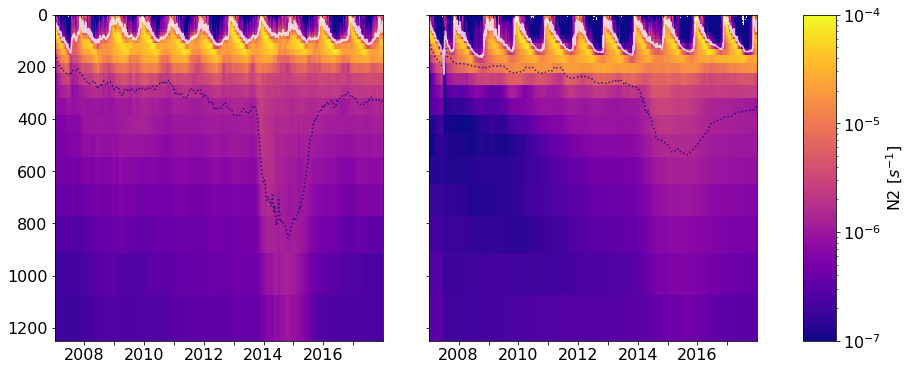

In [85]:
#Figure of spatial average of T and S properties
n_lev=16
col = cmr.take_cmap_colors(cmo.thermal, n_lev, return_fmt='hex')

col[-1]='#faf0e6'
colors_halo=mcolors.LinearSegmentedColormap.from_list('colormap', col)
print(len(col))

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig,axes=plt.subplots(1,3,figsize=(14,6),gridspec_kw={'width_ratios':[1,1,0.1]})
ax=axes[0]
ax.pcolormesh(P.T,T.T,N2_ha.T,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma')
#ct1=ds36.T_mean_ha.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
c1=ds36.sig0_ha36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_ha.plot(ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_title('') 
#ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(1250,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

ax=axes[1]
ct1=ax.pcolormesh(P.T,T.T,N2_tc.T,norm=LogNorm(vmin=1e-7,vmax=1e-4),cmap='plasma')
c3=ds36.sig0_tc36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_tc.plot(ax=ax,color='w',alpha=.75)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1250,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

plt.colorbar(ct1,cax=axes[2],orientation="vertical",label='N2 [$s^{-2}$]')#,ticks=np.arange(1e-7,1.25,0.25))


In [83]:
gsw.Nsquared?

Signature: gsw.Nsquared(SA, CT, p, lat=None, axis=0)
Docstring:
Calculate the square of the buoyancy frequency.

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
CT : array-like
    Conservative Temperature (ITS-90), degrees C
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar
lat : array-like, 1-D, optional
    Latitude, degrees.
axis : int, optional
    The dimension along which pressure increases.

Returns
-------
N2 : array
    Buoyancy frequency-squared at pressure midpoints, 1/s.
    The shape along the pressure axis dimension is one
    less than that of the inputs.
p_mid : array
    Pressure at midpoints of p, dbar.
    The array shape matches N2.
File:      ~/anaconda3/lib/python3.8/site-packages/gsw/stability.py
Type:      function


16


<ipython-input-6-2045f49bba73>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])


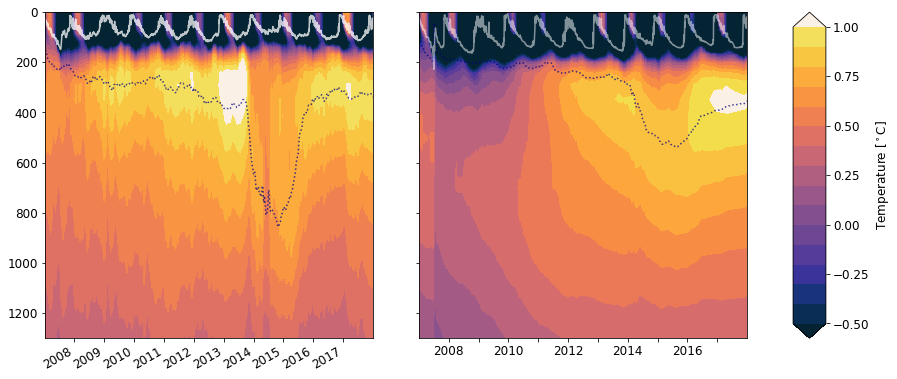

In [6]:
#Figure of spatial average of T and S properties
n_lev=16
col = cmr.take_cmap_colors(cmo.thermal, n_lev, return_fmt='hex')

col[-1]='#faf0e6'
colors_halo=mcolors.LinearSegmentedColormap.from_list('colormap', col)
print(len(col))

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig,axes=plt.subplots(1,3,figsize=(14,6),gridspec_kw={'width_ratios':[1,1,0.1]})
ax=axes[0]
ct1=ds36.T_mean_ha.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)
c1=ds36.sig0_ha36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_ha.plot(ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
#ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

ax=axes[1]
ds36.T_mean_tc.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=ds36.sig0_tc36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_tc.plot(ax=ax,color='w',alpha=.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

plt.colorbar(ct1,cax=axes[2],orientation="vertical",label='Temperature [$^\circ$C]',ticks=np.arange(-.5,1.25,0.25))


16


<ipython-input-7-00e4bb830e00>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])


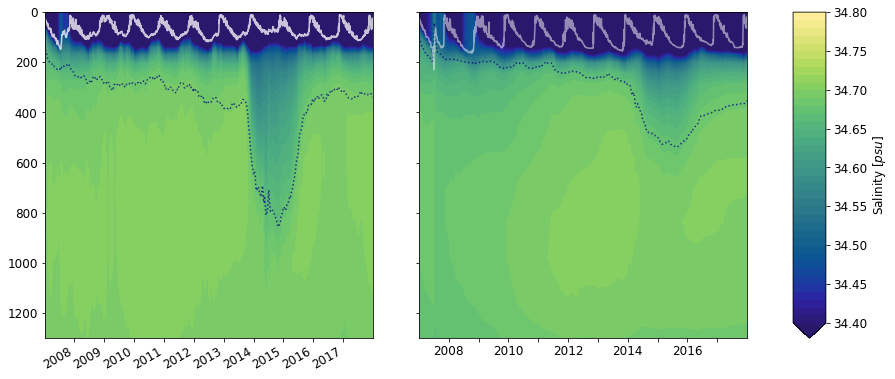

In [7]:
#Figure of spatial average of T and S properties
n_lev=16
col = cmr.take_cmap_colors(cmo.thermal, n_lev, return_fmt='hex')

col[-1]='#faf0e6'
colors_halo=mcolors.LinearSegmentedColormap.from_list('colormap', col)
print(len(col))

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig,axes=plt.subplots(1,3,figsize=(14,6),gridspec_kw={'width_ratios':[1,1,0.1]})
ax=axes[0]
ct1=ds36.S_mean_ha.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.8,levels=41,add_colorbar=False)
c1=ds36.sig0_ha36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_ha.plot(ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
#ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

ax=axes[1]
ds36.S_mean_tc.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.8,levels=41,add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=ds36.sig0_tc36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_tc.plot(ax=ax,color='w',alpha=.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.colorbar(ct1,cax=axes[2],orientation="vertical",label='Salinity [$psu$]')#,ticks=np.arange(-.5,1.25,0.25))

<ipython-input-28-dec6d79d35ca>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])


AttributeError: 'Dataset' object has no attribute 'N2_mean_ha'

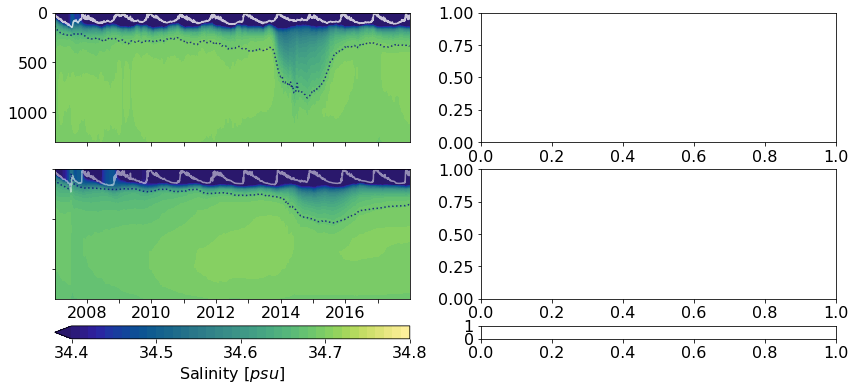

In [28]:


fig,axes=plt.subplots(3,2,figsize=(14,6),gridspec_kw={'height_ratios':[1,1,0.1],'hspace':.3})
ax=axes[0,0]
cs1=ds36.S_mean_ha.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.8,levels=41,add_colorbar=False)
c1=ds36.sig0_ha36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_ha.plot(ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

ax=axes[1,0]
ds36.S_mean_tc.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap=cmo.haline,vmin=34.4,vmax=34.8,levels=41,add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=ds36.sig0_tc36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_tc.plot(ax=ax,color='w',alpha=.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.colorbar(cs1,cax=axes[2,0],orientation="horizontal",label='Salinity [$psu$]',ticks=np.arange(34.4,34.9,0.1))



ax=axes[0,1]
cn1=ds36.N2_mean_ha.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap='plasma',vmin=34.4,vmax=34.8,levels=41,add_colorbar=False)
c1=ds36.sig0_ha36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_ha.plot(ax=ax,color='w',alpha=.75,linestyle='-')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels('')
#ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))

ax=axes[1,1]
ds36.N2_mean_tc.rolling(t=5,center=True).mean().plot.contourf(x='t',y='depth',ax=ax,cmap='plasma',vmin=34.4,vmax=34.8,levels=41,add_colorbar=False)#,cmap=colors_halo,vmin=-.5,vmax=1.,levels=n_lev,add_colorbar=False)#,hatches=['//','//','//','//','//','//','//','//','//','//','','','','','',''])
c3=ds36.sig0_tc36.rolling(t=7,center=True).mean().plot.contour(x='t',y='depth',ax=ax,levels=[27.67],colors='navy',alpha=.75,linestyles=':')
ds36.MLD_mean_tc.plot(ax=ax,color='w',alpha=.5)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('') 
ax.set_xticklabels(['','2008','','2010','','2012','','2014','','2016',''])
plt.setp(ax.get_xticklabels(), ha="center", rotation=0)
ax.set_yticklabels('')
ax.set_ylim(1300,0)
ax.set_xlim((time_array36[1],time_array36[-163]))
plt.colorbar(cn1,cax=axes[2,1],orientation="horizontal",label='Salinity [$psu$]',ticks=np.arange(34.4,34.9,0.1))

AttributeError: 'Dataset' object has no attribute 'Tint_dest'

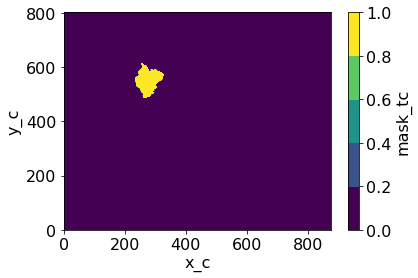

In [8]:
# compute heat content of the 50 to 600m of the water column, according to de Steur
# they compute the heat anomaly wrt the lowest observed value. 
mask_all=ds36.mask_tc#+ds36.mask_tr
mask_all.plot.contourf()

hc_dest=((ds36.Tint_dest)*rho*cp)
# find the minimum value, here we look for the minimumvalue within the defined TC
hc_min_tc_daily=hc_dest.where(mask_all==1).min(dim={'x_c','y_c'})
hc_min_tc_abs=hc_dest.where(mask_all==1).min(dim={'x_c','y_c','t'})

# now compute the heat content anomaly
hca_daily=hc_dest-hc_min_tc_daily
hca_abs=hc_dest-hc_min_tc_abs




In [11]:
#Figure of spatial average of T and S properties
n_lev=5
col_hca = cmr.take_cmap_colors('Spectral_r', n_lev, return_fmt='hex')
colors_hca=mcolors.LinearSegmentedColormap.from_list('colormap', col_hca)
print(len(col_hca))

5


/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


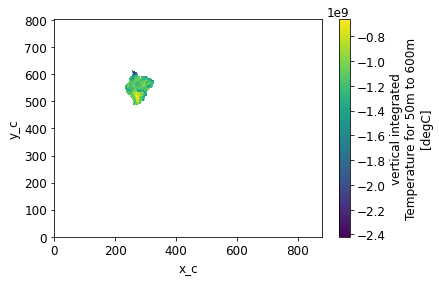

In [20]:
hc_dest.where(mask_all==1).min(dim={'t'}).plot.pcolormesh()


Text(0.5, 0.98, '2007-07-28')

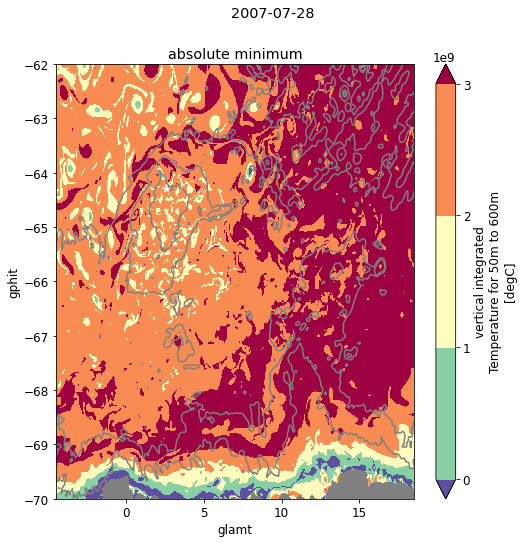

In [22]:
fig,axes=plt.subplots(1,1,figsize=(8,8))
ax=axes
hca_abs.isel(t=208).plot.pcolormesh(x="glamt",y="gphit",ax=ax,vmin=0,vmax=3e9,levels=4,cmap=colors_hca)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
plt.plot(2.56,-64.3,'w*')
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('absolute minimum')
plt.suptitle('%s' %np.datetime_as_string(ds36.t.isel(t=208),unit='D'))

Text(0.5, 0.98, '2014-09-03')

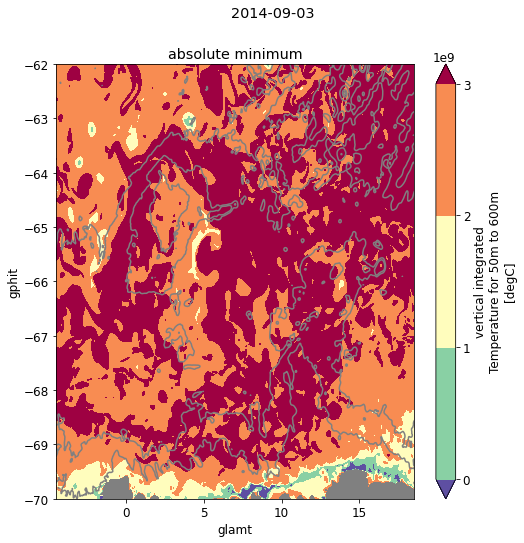

In [21]:
fig,axes=plt.subplots(1,1,figsize=(8,8))
ax=axes
hca_abs.isel(t=2800).plot.contourf(x="glamt",y="gphit",ax=ax,vmin=0,vmax=3e9,levels=4,cmap=colors_hca)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('absolute minimum')
plt.suptitle('%s' %np.datetime_as_string(ds36.t.isel(t=2800),unit='D'))

Text(0.5, 1.0, '2009-09-28')

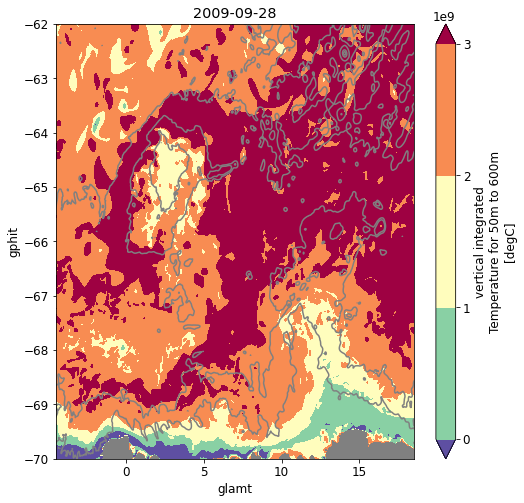

In [24]:
fig,axes=plt.subplots(1,1,figsize=(8,8))
ax=axes
hca_abs.isel(t=1000).plot.contourf(x="glamt",y="gphit",ax=ax,vmin=0,vmax=3e9,levels=4,cmap=colors_hca)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('absolute minimum')

plt.title('%s' %np.datetime_as_string(ds36.t.isel(t=1000),unit='D'))

In [28]:
# MLD Maps
ds36

<xarray.Dataset>
Dimensions:      (t: 4178, x_c: 879, y_c: 804, z_c: 50)
Coordinates:
  * t            (t) datetime64[ns] 2007-01-01T12:00:00 ... 2018-06-11T12:00:00
  * x_c          (x_c) int64 0 1 2 3 4 5 6 7 ... 871 872 873 874 875 876 877 878
  * y_c          (y_c) int64 0 1 2 3 4 5 6 7 ... 796 797 798 799 800 801 802 803
  * z_c          (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    glamt        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    gphit        (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    month        (t) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 5 6 6 6 6 6 6 6 6 6 6 6
    year         (t) int64 2007 2007 2007 2007 2007 ... 2018 2018 2018 2018 2018
    day          (t) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11
    depth        (z_c) float64 1.022 2.096 3.233 ... 5.052e+03 5.5e+03 5.958e+03
Data variables: (12/16)
    MLD_mean_ha  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    MLD_mean_tc  (t) float32 dask.array<chunksize=(31,), meta=np.ndarray>
    S_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    S_mean_tc    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    T_mean_ha    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    T_mean_tc    (t, z_c) float32 dask.array<chunksize=(31, 50), meta=np.ndarray>
    ...           ...
    mask_ha      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_ha_mod  (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tc      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    mask_tr      (y_c, x_c) float64 dask.array<chunksize=(804, 879), meta=np.ndarray>
    sig0_ha36    (t, z_c) float64 dask.array<chunksize=(31, 50), meta=np.ndarray>
    sig0_tc36    (t, z_c) float64 dask.array<chunksize=(31, 50), meta=np.ndarray>

/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/birte/anaconda3/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarn

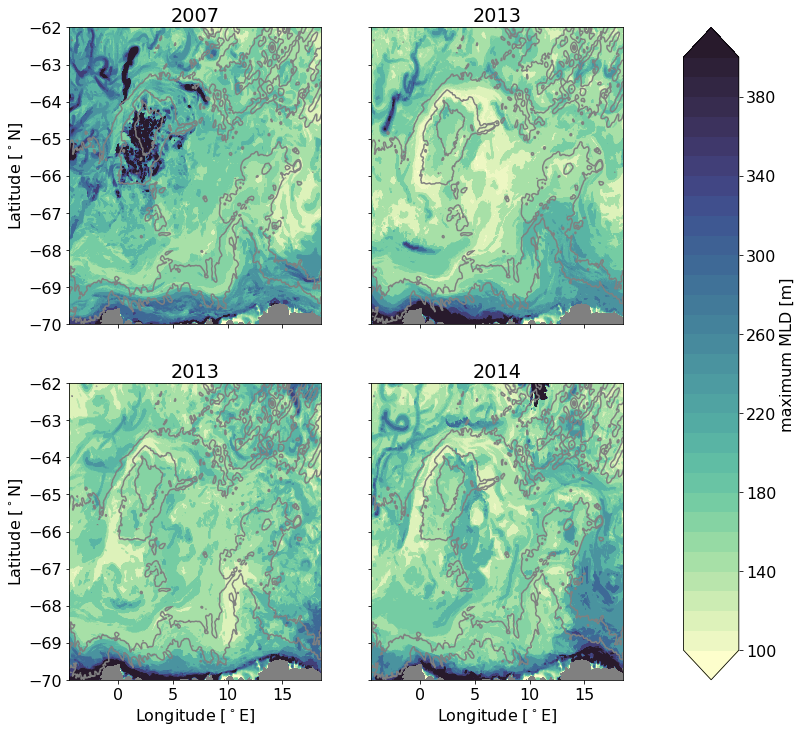

In [7]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(1,2, width_ratios=[1,.1],wspace=.2)#,wspace=0.3)
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1], width_ratios=[1])
gs2 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], width_ratios=[1,1])
col_ax = fig.add_subplot(gs1[0,0])
ax1 = fig.add_subplot(gs2[0,0])
ax2 = fig.add_subplot(gs2[0,1])
ax3 = fig.add_subplot(gs2[1,0])
ax4 = fig.add_subplot(gs2[1,1])

vamin = 100
vamax = 400
lev   = 31
ax=ax1
ds36.mldr10_1.where(ds36.year==2007).max(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.deep,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2007')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Latitude [$^\circ$N]')
ax=ax2
ds36.mldr10_1.where(ds36.year==2009).max(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.deep,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2013')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax=ax3
ds36.mldr10_1.where(ds36.year==2013).max(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.deep,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2013')
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax=ax4
cbm=ds36.mldr10_1.where(ds36.year==2014).max(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.deep,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2014')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Longitude [$^\circ$E]')

plt.colorbar(cbm,cax=col_ax,label='maximum MLD [m]')
plt.savefig('./max_mld_m36.jpg',dpi=300)

/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


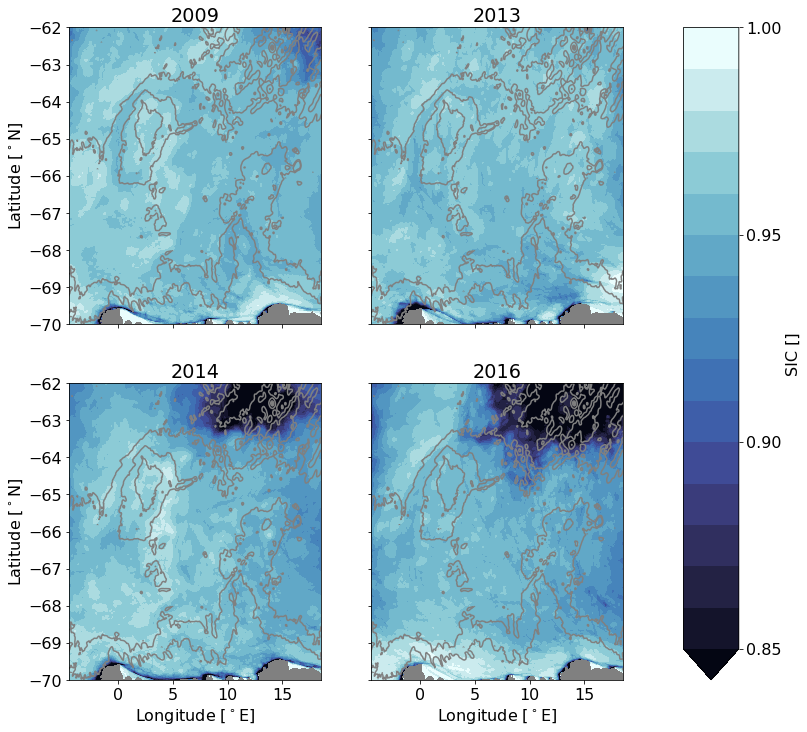

In [10]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(1,2, width_ratios=[1,.1],wspace=.2)#,wspace=0.3)
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1], width_ratios=[1])
gs2 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], width_ratios=[1,1])
col_ax = fig.add_subplot(gs1[0,0])
ax1 = fig.add_subplot(gs2[0,0])
ax2 = fig.add_subplot(gs2[0,1])
ax3 = fig.add_subplot(gs2[1,0])
ax4 = fig.add_subplot(gs2[1,1])

vamin = 0.85
vamax = 1
lev   = 16

ax=ax1
ds36.siconc.where((ds36.year==2009)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2009')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Latitude [$^\circ$N]')
ax=ax2
ds36.siconc.where((ds36.year==2013)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2013')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax=ax3
ds36.siconc.where((ds36.year==2014)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2014')
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax=ax4
cbm=ds36.siconc.where((ds36.year==2016)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2016')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Longitude [$^\circ$E]')

plt.colorbar(cbm,cax=col_ax,label='SIC []',ticks=np.linspace(vamin,vamax,4))

/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/birte/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


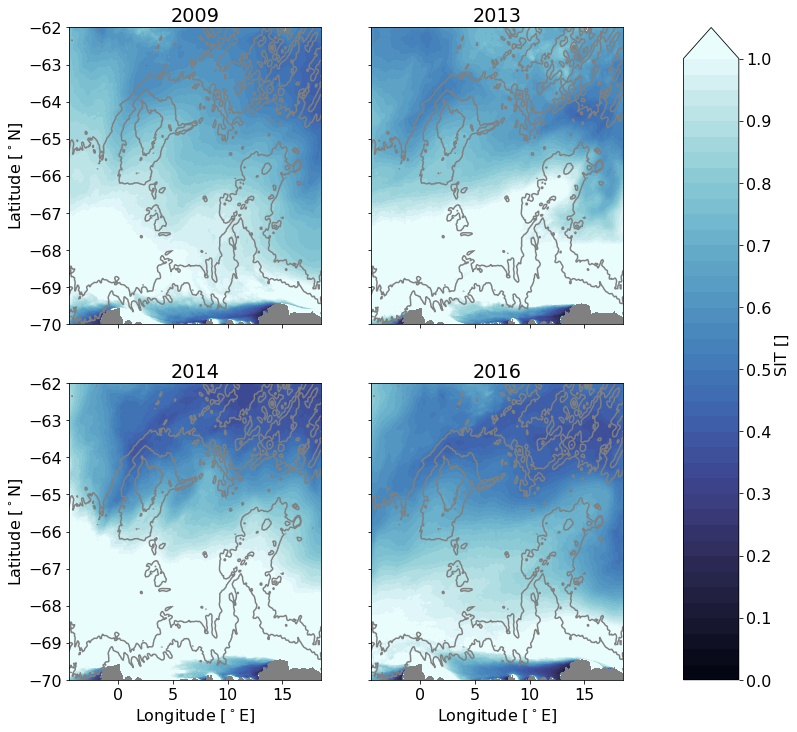

In [11]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(1,2, width_ratios=[1,.1],wspace=.2)#,wspace=0.3)
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1], width_ratios=[1])
gs2 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], width_ratios=[1,1])
col_ax = fig.add_subplot(gs1[0,0])
ax1 = fig.add_subplot(gs2[0,0])
ax2 = fig.add_subplot(gs2[0,1])
ax3 = fig.add_subplot(gs2[1,0])
ax4 = fig.add_subplot(gs2[1,1])

vamin = 0
vamax = 1
lev   = 41

ax=ax1
ds36.sithic.where((ds36.year==2009)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2009')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Latitude [$^\circ$N]')
ax=ax2
ds36.sithic.where((ds36.year==2013)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2013')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax=ax3
ds36.sithic.where((ds36.year==2014)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2014')
ax.set_ylabel('Latitude [$^\circ$N]')
ax.set_xlabel('Longitude [$^\circ$E]')
ax=ax4
cbm=ds36.sithic.where((ds36.year==2016)&(ds36.month>6)&(ds36.month<10)).mean(dim='t').plot.contourf(x="glamt",y="gphit",ax=ax,vmin=vamin,vmax=vamax,levels=lev,cmap=cmo.ice,add_colorbar=False)
ds36.bathy_meter.plot.contour(x="glamt",y="gphit",ax=ax,levels=[2500,3500,5000],colors='grey')
ds36.bathy_meter.where(ds36.bathy_meter<1).plot.contourf(x="glamt",y="gphit",ax=ax,colors='gray',add_colorbar=False)
ax.set_xlim((-4.5,18.5))
ax.set_ylim(-70,-62)
ax.set_title('2016')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xlabel('Longitude [$^\circ$E]')

plt.colorbar(cbm,cax=col_ax,label='SIT []',ticks=np.linspace(vamin,vamax,11))